#S&P 500 and EURO STOXX 500 Analysis

The following notebook contains an analysis of S&P 500 and EURO STOXX 50 stock indices.

##Data Analysis

In [353]:
import pandas as pd
import numpy as np

data_sp_500=r'/content/sp500.csv'
data_euro_stoxx_50=r'/content/euro50.csv'

The analysis starts by finding some preliminary information on the available datasets.

In [354]:
df=pd.read_csv(data_sp_500)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2517 entries, 0 to 2516
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2517 non-null   object 
 1   Open    2517 non-null   float64
 2   High    2517 non-null   float64
 3   Low     2517 non-null   float64
 4   Close   2517 non-null   float64
 5   Volume  2517 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 118.1+ KB


In [355]:
df1=pd.read_csv(data_euro_stoxx_50)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2512 non-null   object 
 1   Open    2512 non-null   float64
 2   High    2512 non-null   float64
 3   Low     2512 non-null   float64
 4   Close   2512 non-null   float64
 5   Volume  2512 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 117.9+ KB


The 'Date' column of type object is converted into datetime type.

In [356]:
df['Date'] = df['Date'].str[:-6]
df['Date']=pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2517 entries, 0 to 2516
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2517 non-null   datetime64[ns]
 1   Open    2517 non-null   float64       
 2   High    2517 non-null   float64       
 3   Low     2517 non-null   float64       
 4   Close   2517 non-null   float64       
 5   Volume  2517 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 118.1 KB


In [357]:
df1['Date'] = df1['Date'].str[:-6]
df1['Date']=pd.to_datetime(df1['Date'])
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2512 non-null   datetime64[ns]
 1   Open    2512 non-null   float64       
 2   High    2512 non-null   float64       
 3   Low     2512 non-null   float64       
 4   Close   2512 non-null   float64       
 5   Volume  2512 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 117.9 KB


Columns 'Month' and 'Year' are added to simplify the calculation of returns.

In [358]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

In [359]:
df1['Year'] = df1['Date'].dt.year
df1['Month'] = df1['Date'].dt.month

A function is defined that calculates monthly yields. Following the specification, months for which there are not at least 20 days of data will have an associated yield value of NaN.

In [360]:
def monthly_return(group, df):
    """
    Calculate the monthly return based on the last day of the current month and the last day of the previous month.

    Parameters:
    group (pd.DataFrame): A DataFrame group containing data for a single month.
    df (pd.DataFrame): The original DataFrame containing all the data.

    Returns:
    float: The monthly return. Returns NaN if there are less than 20 trading days
           in the month or if data for the previous month is not available.
      """
    if len(group) < 20:
        return np.nan

    end_price = group['Close'].iloc[-1]
    current_month = group['Month'].iloc[0]
    current_year = group['Year'].iloc[0]
    prev_month = current_month - 1 if current_month != 1 else 12
    prev_year = current_year if current_month != 1 else current_year - 1
    prev_group = df[(df['Year'] == prev_year) & (df['Month'] == prev_month)]

    if len(prev_group) == 0:
        return np.nan

    start_price = prev_group['Close'].iloc[-1]
    try:
        return (end_price / start_price) - 1
    except ZeroDivisionError:
        return np.nan

The monthly percentage return is calculated. The result of the calculation is added to the source dataframe.

In [361]:
sp500_monthly_returns = df.groupby(['Year', 'Month']).apply(lambda group: monthly_return(group, df)).reset_index(name='Monthly_Return')
df = pd.merge(df, sp500_monthly_returns, on=['Year', 'Month'], how='left')
print(sp500_monthly_returns)

     Year  Month  Monthly_Return
0    2014      4             NaN
1    2014      5        0.023206
2    2014      6        0.020645
3    2014      7       -0.013438
4    2014      8        0.039464
..    ...    ...             ...
116  2023     12        0.045655
117  2024      1        0.015926
118  2024      2        0.052187
119  2024      3        0.032702
120  2024      4             NaN

[121 rows x 3 columns]


In [362]:
eur_50_monthly_returns = df1.groupby(['Year', 'Month']).apply(lambda group: monthly_return(group, df1)).reset_index(name='Monthly_Return')
df1 = pd.merge(df1, eur_50_monthly_returns, on=['Year', 'Month'], how='left')
print(eur_50_monthly_returns)

     Year  Month  Monthly_Return
0    2014      4             NaN
1    2014      5        0.014448
2    2014      6       -0.005042
3    2014      7       -0.034920
4    2014      8        0.018334
..    ...    ...             ...
116  2023     12             NaN
117  2024      1        0.028032
118  2024      2        0.049344
119  2024      3        0.042161
120  2024      4             NaN

[121 rows x 3 columns]


A function is defined to calculate the annual percentage returns. As per the specification, if less than 252 days of data are available for a year, then the value NaN will be returned.

In [363]:
def annual_return(group, df):
    """
    Calculate the annual return based on the last day's closing price of the current year
    and the last day's closing price of the previous year.

    Parameters:
    group (pd.DataFrame): A DataFrame group containing data for a single year.
    df (pd.DataFrame): The original DataFrame containing all the data.

    Returns:
    float: The annual return in percentage. Returns NaN if there are less than 252 trading days
           in the year or if data for the previous year is not available.
    """
    if len(group) < 252:
        return np.nan

    end_price = group['Close'].iloc[-1]
    prev_year_group = df[df['Year'] == group['Year'].iloc[0] - 1]
    if len(prev_year_group) == 0:
        return np.nan
    start_price = prev_year_group['Close'].iloc[-1]
    try:
        annual_return = (end_price - start_price) / start_price * 100
        return annual_return
    except ZeroDivisionError:
        return np.nan

The annual percentage return is calculated. The result is merged with the starting dataframe.

In [364]:
sp500_annual_returns = df.groupby('Year').apply(lambda group: annual_return(group, df)).reset_index(name='Annual_Return')
df = df.merge(sp500_annual_returns, on='Year', how='left')
df.head()

,Date,Open,High,Low,Close,Volume,Year,Month,Monthly_Return,Annual_Return
0,2014-04-15,153.202298,154.046360,151.689653,153.937714,157093000,2014,4,NaN,NaN
1,2014-04-16,154.999072,155.558996,154.313784,155.550644,105197000,2014,4,NaN,NaN
2,2014-04-17,155.341722,156.202502,155.074289,155.767929,105255000,2014,4,NaN,NaN
3,2014-04-21,155.809663,156.361234,155.617453,156.311081,68329000,2014,4,NaN,NaN
4,2014-04-22,156.469867,157.447646,156.386304,157.021439,85790000,2014,4,NaN,NaN


In [365]:
eur50_annual_returns = df1.groupby('Year').apply(lambda group: annual_return(group, df1)).reset_index(name='Annual_Return')
df1 = df1.merge(eur50_annual_returns, on='Year', how='left')
df1.head()

,Date,Open,High,Low,Close,Volume,Year,Month,Monthly_Return,Annual_Return
0,2014-04-15,3130.149902,3139.659912,3091.189941,3091.520020,59163400,2014,4,NaN,NaN
1,2014-04-16,3116.459961,3139.260010,3113.469971,3139.260010,63114700,2014,4,NaN,NaN
2,2014-04-17,3140.120117,3156.639893,3121.820068,3155.810059,66521300,2014,4,NaN,NaN
3,2014-04-22,3161.689941,3201.250000,3157.399902,3199.689941,49270000,2014,4,NaN,NaN
4,2014-04-23,3197.389893,3198.600098,3175.219971,3175.969971,48916800,2014,4,NaN,NaN


The average daily return by day of the week and by index is calculated.

In [366]:
df['Daily_Return'] = df['Close'].pct_change() * 100
df['Day_of_Week'] = df['Date'].dt.day_name()

sp500_mean_daily_returns = df.groupby('Day_of_Week')['Daily_Return'].mean().reset_index()
df = df.merge(sp500_mean_daily_returns, on='Day_of_Week', how='left', suffixes=('', '_Mean'))
df.rename(columns={'Daily_Return_Mean': 'Mean_Daily_Return'}, inplace=True)
df.head()

,Date,Open,High,Low,Close,Volume,Year,Month,Monthly_Return,Annual_Return,Daily_Return,Day_of_Week,Mean_Daily_Return
0,2014-04-15,153.202298,154.046360,151.689653,153.937714,157093000,2014,4,NaN,NaN,NaN,Tuesday,0.051571
1,2014-04-16,154.999072,155.558996,154.313784,155.550644,105197000,2014,4,NaN,NaN,1.047781,Wednesday,0.078946
2,2014-04-17,155.341722,156.202502,155.074289,155.767929,105255000,2014,4,NaN,NaN,0.139688,Thursday,0.038828
3,2014-04-21,155.809663,156.361234,155.617453,156.311081,68329000,2014,4,NaN,NaN,0.348693,Monday,0.048327
4,2014-04-22,156.469867,157.447646,156.386304,157.021439,85790000,2014,4,NaN,NaN,0.454451,Tuesday,0.051571


In [367]:
df1['Daily_Return'] = df1['Close'].pct_change() * 100
df1['Day_of_Week'] = df1['Date'].dt.day_name()

eur50_mean_daily_returns = df1.groupby('Day_of_Week')['Daily_Return'].mean().reset_index()
df1 = df1.merge(eur50_mean_daily_returns, on='Day_of_Week', how='left', suffixes=('', '_Mean'))
df1.rename(columns={'Daily_Return_Mean': 'Mean_Daily_Return'}, inplace=True)
df1.head()

,Date,Open,High,Low,Close,Volume,Year,Month,Monthly_Return,Annual_Return,Daily_Return,Day_of_Week,Mean_Daily_Return
0,2014-04-15,3130.149902,3139.659912,3091.189941,3091.520020,59163400,2014,4,NaN,NaN,NaN,Tuesday,0.108546
1,2014-04-16,3116.459961,3139.260010,3113.469971,3139.260010,63114700,2014,4,NaN,NaN,1.544224,Wednesday,0.098675
2,2014-04-17,3140.120117,3156.639893,3121.820068,3155.810059,66521300,2014,4,NaN,NaN,0.527196,Thursday,-0.047067
3,2014-04-22,3161.689941,3201.250000,3157.399902,3199.689941,49270000,2014,4,NaN,NaN,1.390448,Tuesday,0.108546
4,2014-04-23,3197.389893,3198.600098,3175.219971,3175.969971,48916800,2014,4,NaN,NaN,-0.741321,Wednesday,0.098675


The days with the highest and lowest returns are identified and for these, some information about the price trend and the day of the week is given.

In [368]:
sp500_max_return_day = df.loc[df['Daily_Return'].idxmax()]
sp500_min_return_day = df.loc[df['Daily_Return'].idxmin()]

columns_of_interest=['Date','Open','High','Low','Close','Daily_Return','Day_of_Week']
print("Day with highest daily return:")
print(sp500_max_return_day[columns_of_interest])
print("\nDay with lowest daily return:")
print(sp500_min_return_day[columns_of_interest])

Day with highest daily return:
Date            2020-03-24 00:00:00
Open                     220.732909
High                      229.84773
Low                      220.149113
Close                    228.953186
Daily_Return               9.060337
Day_of_Week                 Tuesday
Name: 1495, dtype: object

Day with lowest daily return:
Date            2020-03-16 00:00:00
Open                     225.770616
High                     240.486241
Low                      222.194689
Close                    224.525604
Daily_Return             -10.942383
Day_of_Week                  Monday
Name: 1489, dtype: object


In [369]:
eur50_max_return_day = df1.loc[df1['Daily_Return'].idxmax()]
eur50_min_return_day = df1.loc[df1['Daily_Return'].idxmin()]

print("Day with highest daily return:")
print(eur50_max_return_day[columns_of_interest])
print("\nDay with lowest daily return:")
print(eur50_min_return_day[columns_of_interest])

Day with highest daily return:
Date            2020-03-24 00:00:00
Open                    2507.610107
High                    2715.110107
Low                     2507.610107
Close                   2715.110107
Daily_Return               9.236225
Day_of_Week                 Tuesday
Name: 1486, dtype: object

Day with lowest daily return:
Date            2020-03-12 00:00:00
Open                        2883.25
High                        2883.25
Low                     2535.889893
Close                    2545.22998
Daily_Return             -12.401398
Day_of_Week                Thursday
Name: 1478, dtype: object


The average daily volume of the two indices is calculated.

In [370]:
sp500_avg_daily_volume=df['Volume'].mean()
eur50_avg_daily_volume=df1['Volume'].mean()
print(f'The average daily volume of the S&P 500 index, calculated over the last 10 years is {sp500_avg_daily_volume.round()}')
print(f'The average daily volume of the EURO STOXX 50 index, calculated over the last 10 years is {eur50_avg_daily_volume.round()}')

The average daily volume of the S&P 500 index, calculated over the last 10 years is 91289038.0
The average daily volume of the EURO STOXX 50 index, calculated over the last 10 years is 41934440.0


##Data Visualization

###Monthly and annual percentage returns for the S&P500 and EURO STOXX 50 indices

The monthly percentage returns for the two indices under analysis are shown below. A 'YearMonth' column is added to improve the visibility of the results.

In [371]:
sp500_monthly_returns['YearMonth'] = sp500_monthly_returns['Year'].astype(str) + '-' + sp500_monthly_returns['Month'].astype(str).str.zfill(2)
eur_50_monthly_returns['YearMonth'] = eur_50_monthly_returns['Year'].astype(str) + '-' + eur_50_monthly_returns['Month'].astype(str).str.zfill(2)

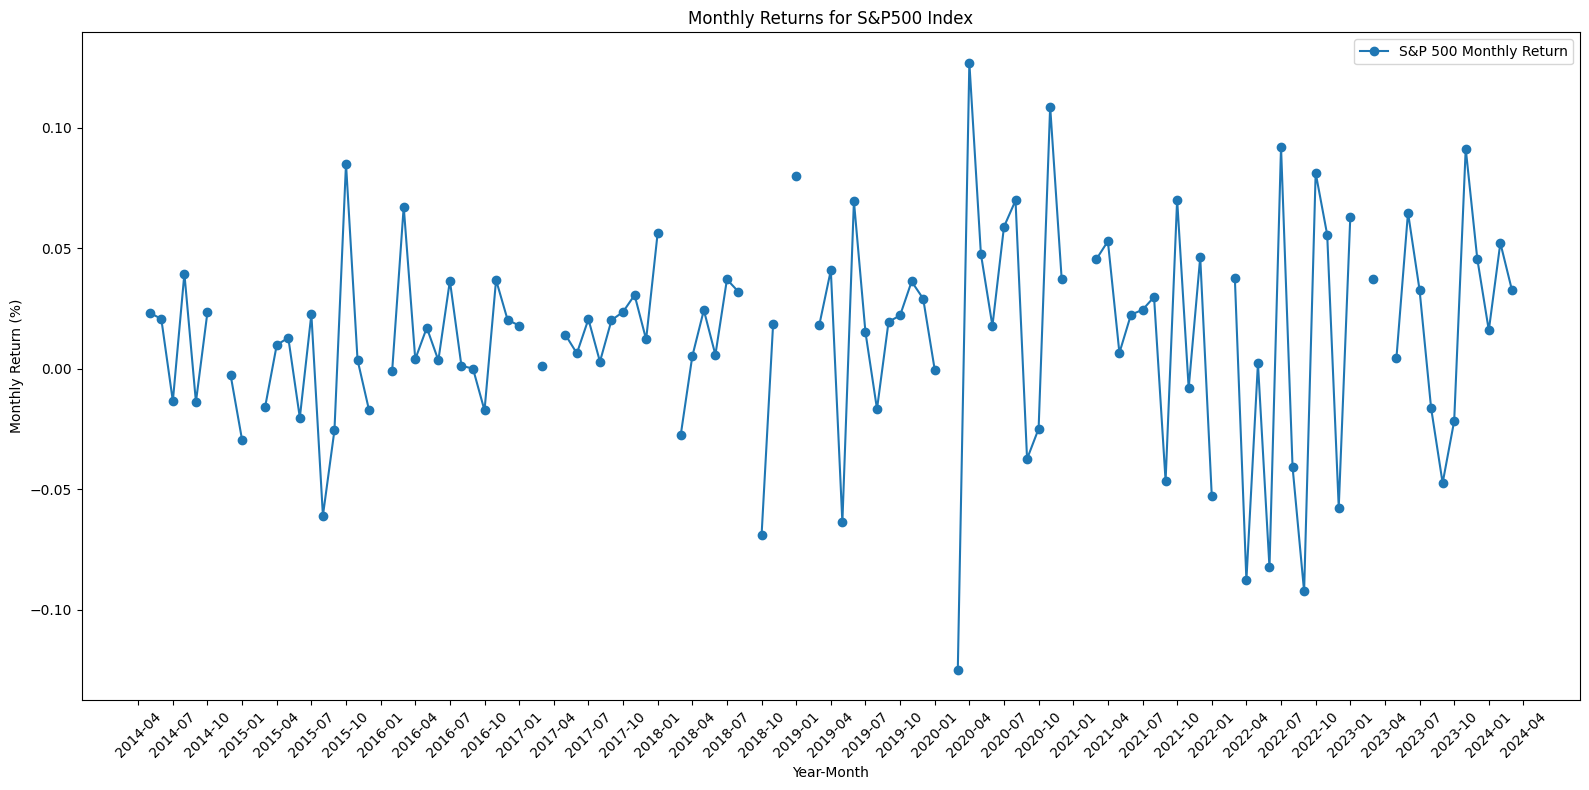

In [372]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(sp500_monthly_returns['YearMonth'], sp500_monthly_returns['Monthly_Return'], marker='o', label='S&P 500 Monthly Return')

plt.xlabel('Year-Month')
plt.ylabel('Monthly Return (%)')
plt.title('Monthly Returns for S&P500 Index')

xticks = np.arange(0, len(sp500_monthly_returns['YearMonth']), step=3)
ax.set_xticks(xticks)
ax.set_xticklabels(sp500_monthly_returns['YearMonth'].iloc[xticks], rotation=45)

plt.legend()
plt.tight_layout()
plt.show()

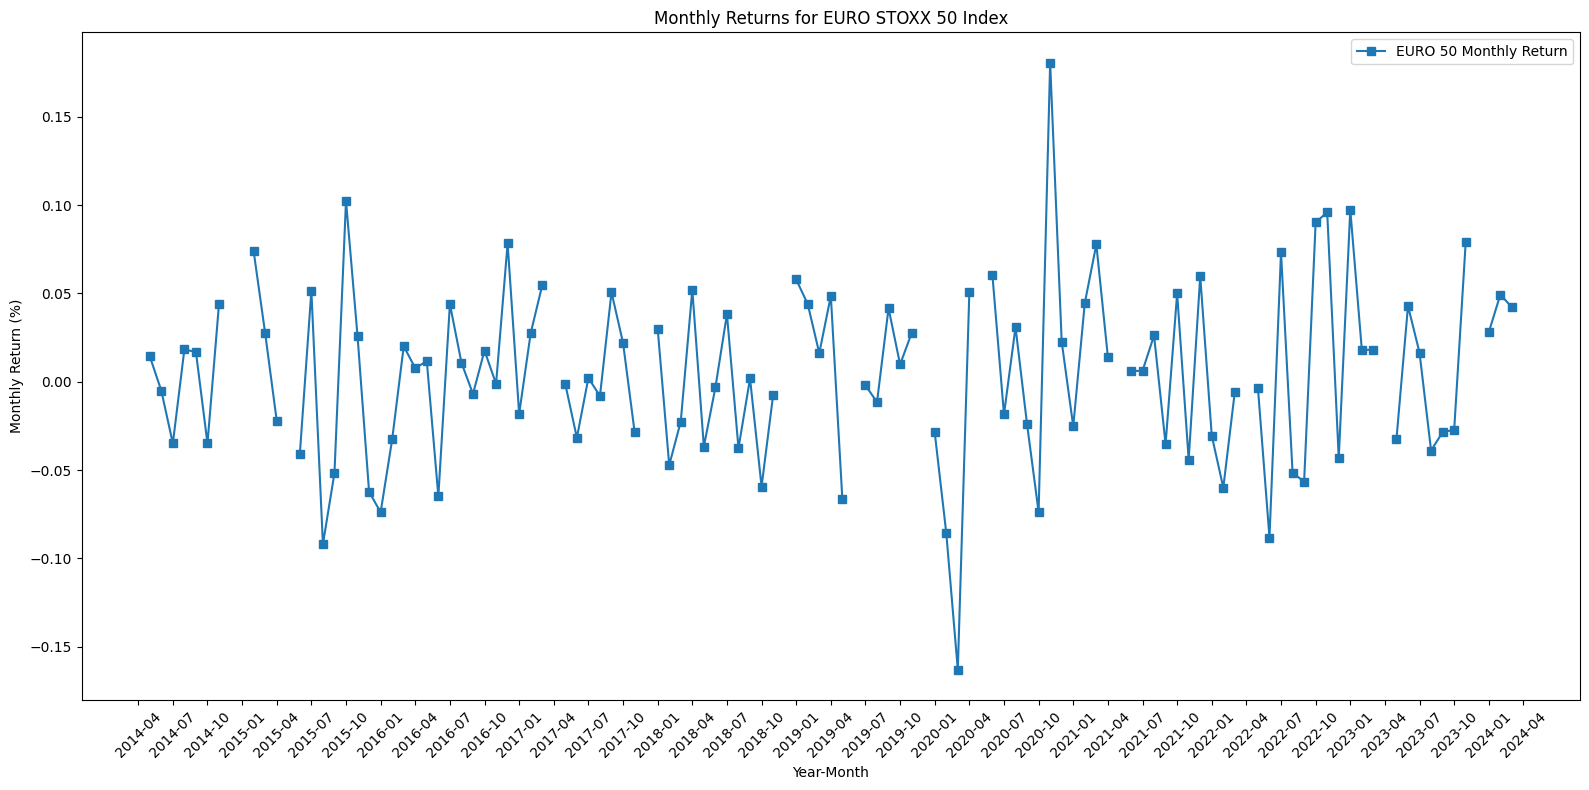

In [373]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(eur_50_monthly_returns['YearMonth'], eur_50_monthly_returns['Monthly_Return'], marker='s', label='EURO 50 Monthly Return')

plt.xlabel('Year-Month')
plt.ylabel('Monthly Return (%)')
plt.title('Monthly Returns for EURO STOXX 50 Index')

xticks = np.arange(0, len(sp500_monthly_returns['YearMonth']), step=3)
ax.set_xticks(xticks)
ax.set_xticklabels(sp500_monthly_returns['YearMonth'].iloc[xticks], rotation=45)

plt.legend()
plt.tight_layout()
plt.show()

Below are the annual percentage return trends for the two indices S&P 500 and EURO STOXX 50.

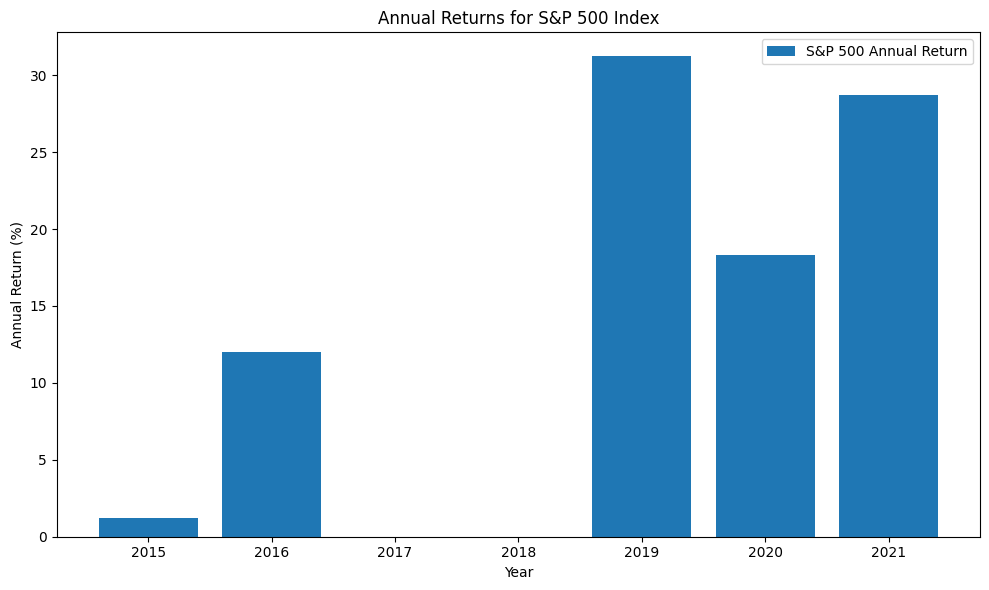

In [374]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(sp500_annual_returns['Year'], sp500_annual_returns['Annual_Return'], label='S&P 500 Annual Return')

plt.xlabel('Year')
plt.ylabel('Annual Return (%)')
plt.title('Annual Returns for S&P 500 Index')
plt.legend()
plt.tight_layout()
plt.show()

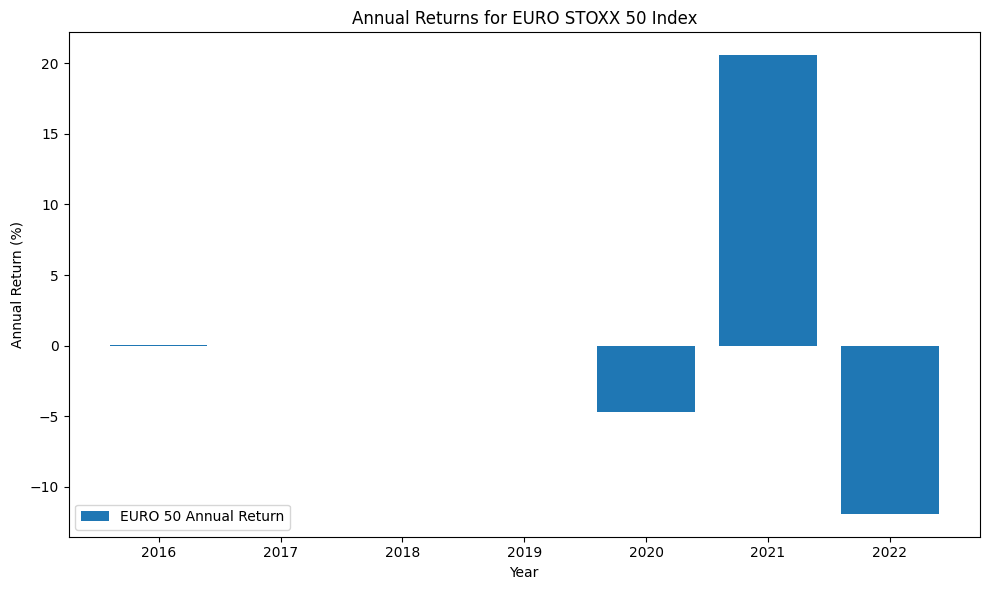

In [375]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(eur50_annual_returns['Year'], eur50_annual_returns['Annual_Return'], label='EURO 50 Annual Return')

plt.xlabel('Year')
plt.ylabel('Annual Return (%)')
plt.title('Annual Returns for EURO STOXX 50 Index')
plt.legend()
plt.tight_layout()
plt.show()

###Comparison of monthly and annual percentage returns of the S&P 500 Index and EURO STOXX 50 Index

A sorting of the data is performed by entering the calculated monthly returns for the two indices into a single dataframe.

In [376]:
monthly_returns_combined = pd.merge(
    sp500_monthly_returns[['YearMonth','Monthly_Return']], eur_50_monthly_returns[['YearMonth','Monthly_Return']],
    on='YearMonth',
    how='outer',
    suffixes=('_SP500','_EURO50')
  ).sort_values('YearMonth')

A comparison of the monthly returns of the two indices is shown.

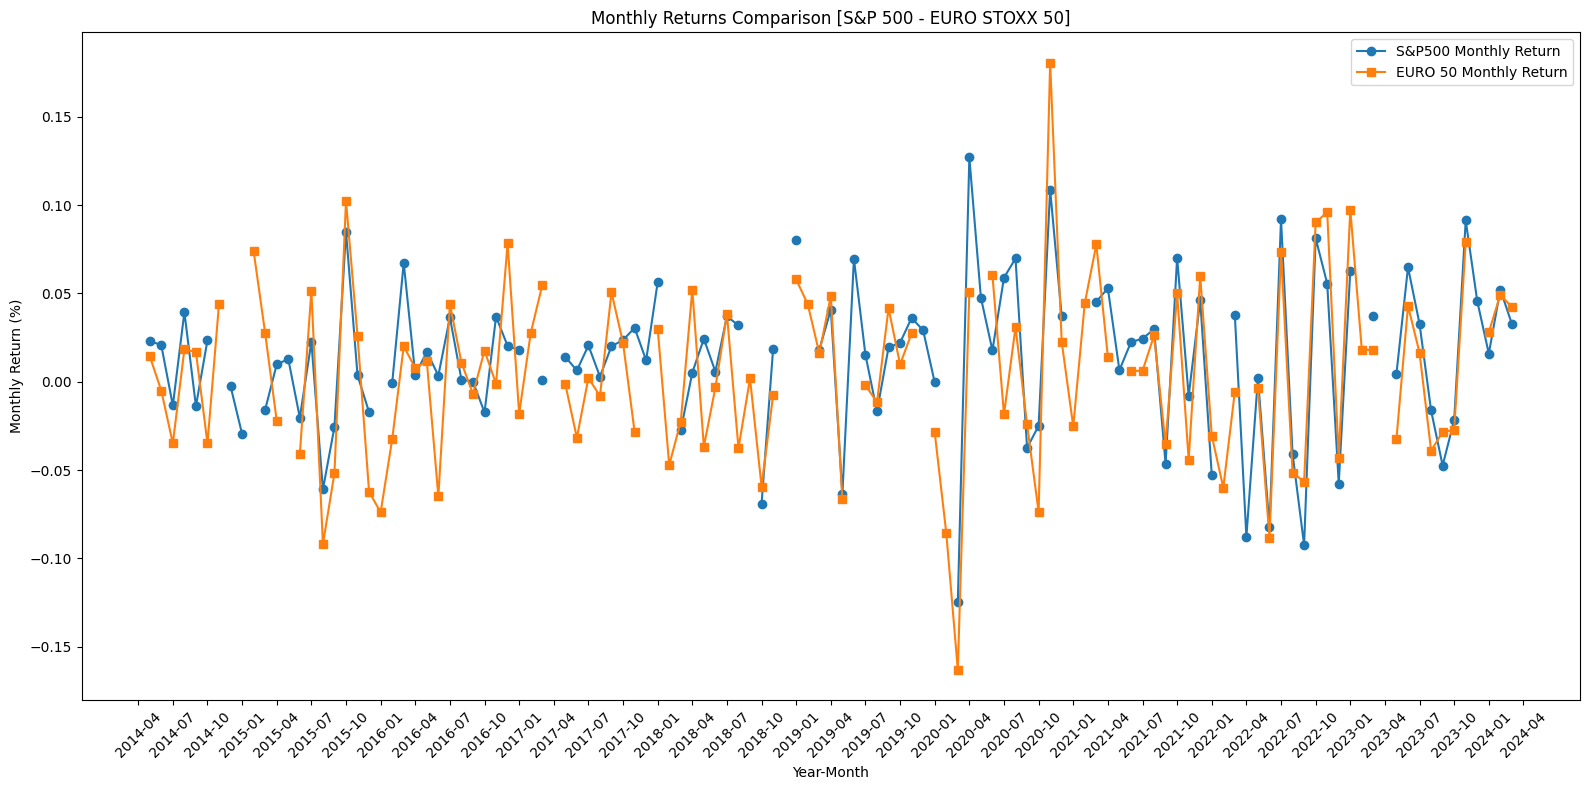

In [377]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(monthly_returns_combined['YearMonth'], monthly_returns_combined['Monthly_Return_SP500'], marker='o', label='S&P500 Monthly Return')
ax.plot(monthly_returns_combined['YearMonth'], monthly_returns_combined['Monthly_Return_EURO50'], marker='s', label='EURO 50 Monthly Return')

plt.xlabel('Year-Month')
plt.ylabel('Monthly Return (%)')
plt.title('Monthly Returns Comparison [S&P 500 - EURO STOXX 50]')

xticks = np.arange(0, len(monthly_returns_combined['YearMonth']), step=3)
ax.set_xticks(xticks)
ax.set_xticklabels(monthly_returns_combined['YearMonth'].iloc[xticks], rotation=45)

plt.legend()
plt.tight_layout()
plt.show()

A comparison of the annual return trends for the two indices is shown.

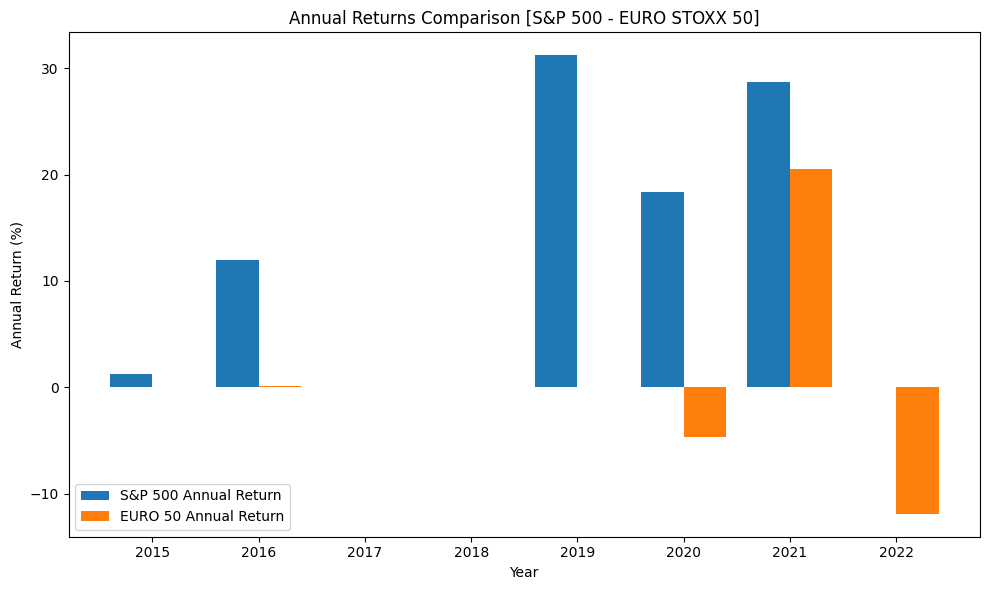

In [378]:
annual_returns_combined = pd.merge(
    sp500_annual_returns, eur50_annual_returns,
    on='Year',
    how='outer',
    suffixes=('_SP500','_EURO50')
  ).sort_values('Year')

plt.figure(figsize=(10, 6))
plt.bar(annual_returns_combined['Year'] - 0.2, annual_returns_combined['Annual_Return_SP500'], width=0.4, label='S&P 500 Annual Return')
plt.bar(annual_returns_combined['Year'] + 0.2, annual_returns_combined['Annual_Return_EURO50'], width=0.4, label='EURO 50 Annual Return')

plt.xlabel('Year')
plt.ylabel('Annual Return (%)')
plt.title('Annual Returns Comparison [S&P 500 - EURO STOXX 50]')
plt.legend()
plt.tight_layout()
plt.show()

The comparison shows that for both indices, there are missing values for several years. Most likely, this is due to the claim made that the calculation should be made for the 252 stock exchange days. Of course, the strict application of the specification does not take into account the variability of the number of working days in a year.

To remedy this anomaly, it is possible to calculate the number of stock exchange days available for the years contained in the datasets under analysis.

In [379]:
def count_days_per_year(df):
    df['Year'] = df['Date'].dt.year
    return df.groupby('Year').size()

days_per_year_sp500 = count_days_per_year(df)
days_per_year_eur50 = count_days_per_year(df1)

print("Number of values per year for SP500:")
print(days_per_year_sp500)
print("\nNumber of values per year for eur50:")
print(days_per_year_eur50)

Number of values per year for SP500:
Year
2014    181
2015    252
2016    252
2017    251
2018    251
2019    252
2020    253
2021    252
2022    251
2023    250
2024     72
dtype: int64

Number of values per year for eur50:
Year
2014    176
2015    250
2016    254
2017    251
2018    249
2019    249
2020    252
2021    254
2022    254
2023    251
2024     72
dtype: int64


As can be seen, with the exception of 2014 and 2024 (for which only a few months' data are available), for the other available years the number of available stock exchange days fluctuates in a very narrow range around the target value of 252 days. In particular, it can be seen that the worst possible data deficiency (except for 2014 and 2024) is of the order of 1.2%. Considering such an approximation as acceptable, it would be possible to recalculate the annual percentage trends considering all available years except 2014 and 2024.

In [380]:
def annual_return_new(group, df):
    """
    Calculate the annual return based on the last day's closing price of the current year
    and the last day's closing price of the previous year.

    Parameters:
    group (pd.DataFrame): A DataFrame group containing data for a single year.
    df (pd.DataFrame): The original DataFrame containing all the data.

    Returns:
    float: The annual return in percentage. Returns NaN if there are less than 249 trading days
           in the year or if data for the previous year is not available.
    """
    if len(group) < 249:
        return np.nan
    end_price = group['Close'].iloc[-1]
    prev_year_group = df[df['Year'] == group['Year'].iloc[0] - 1]

    if len(prev_year_group) == 0:
        return np.nan
    start_price = prev_year_group['Close'].iloc[-1]

    try:
        annual_return = (end_price - start_price) / start_price * 100
        return annual_return
    except ZeroDivisionError:
        return np.nan

In [381]:
sp500_annual_returns_new = df.groupby('Year').apply(lambda group: annual_return_new(group, df)).reset_index(name='Annual_Return_new')
df = df.merge(sp500_annual_returns_new, on='Year', how='left')
df.head()

,Date,Open,High,Low,Close,Volume,Year,Month,Monthly_Return,Annual_Return,Daily_Return,Day_of_Week,Mean_Daily_Return,Annual_Return_new
0,2014-04-15,153.202298,154.046360,151.689653,153.937714,157093000,2014,4,NaN,NaN,NaN,Tuesday,0.051571,NaN
1,2014-04-16,154.999072,155.558996,154.313784,155.550644,105197000,2014,4,NaN,NaN,1.047781,Wednesday,0.078946,NaN
2,2014-04-17,155.341722,156.202502,155.074289,155.767929,105255000,2014,4,NaN,NaN,0.139688,Thursday,0.038828,NaN
3,2014-04-21,155.809663,156.361234,155.617453,156.311081,68329000,2014,4,NaN,NaN,0.348693,Monday,0.048327,NaN
4,2014-04-22,156.469867,157.447646,156.386304,157.021439,85790000,2014,4,NaN,NaN,0.454451,Tuesday,0.051571,NaN


In [382]:
eur50_annual_returns_new = df1.groupby('Year').apply(lambda group: annual_return_new(group, df1)).reset_index(name='Annual_Return_new')
df1 = df1.merge(eur50_annual_returns_new, on='Year', how='left')
df1.head()

,Date,Open,High,Low,Close,Volume,Year,Month,Monthly_Return,Annual_Return,Daily_Return,Day_of_Week,Mean_Daily_Return,Annual_Return_new
0,2014-04-15,3130.149902,3139.659912,3091.189941,3091.520020,59163400,2014,4,NaN,NaN,NaN,Tuesday,0.108546,NaN
1,2014-04-16,3116.459961,3139.260010,3113.469971,3139.260010,63114700,2014,4,NaN,NaN,1.544224,Wednesday,0.098675,NaN
2,2014-04-17,3140.120117,3156.639893,3121.820068,3155.810059,66521300,2014,4,NaN,NaN,0.527196,Thursday,-0.047067,NaN
3,2014-04-22,3161.689941,3201.250000,3157.399902,3199.689941,49270000,2014,4,NaN,NaN,1.390448,Tuesday,0.108546,NaN
4,2014-04-23,3197.389893,3198.600098,3175.219971,3175.969971,48916800,2014,4,NaN,NaN,-0.741321,Wednesday,0.098675,NaN


Below are the recalculated yield trends and a comparison of them.

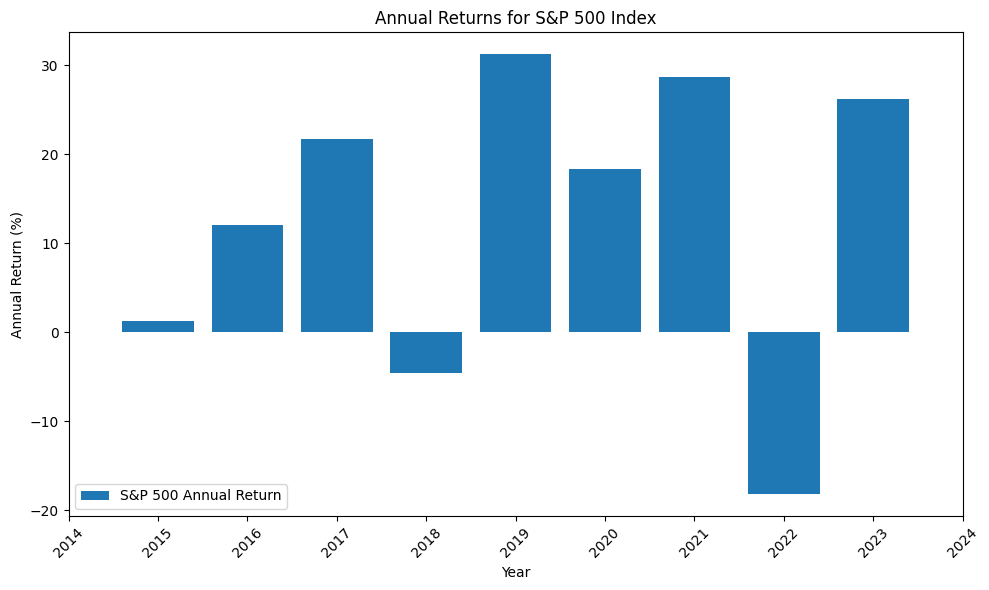

In [383]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(sp500_annual_returns_new['Year'], sp500_annual_returns_new['Annual_Return_new'], label='S&P 500 Annual Return')

ax.set_xticks(sp500_annual_returns_new['Year'])
ax.set_xticklabels(sp500_annual_returns_new['Year'], rotation=45)

plt.xlabel('Year')
plt.ylabel('Annual Return (%)')
plt.title('Annual Returns for S&P 500 Index')
plt.legend()
plt.tight_layout()
plt.show()

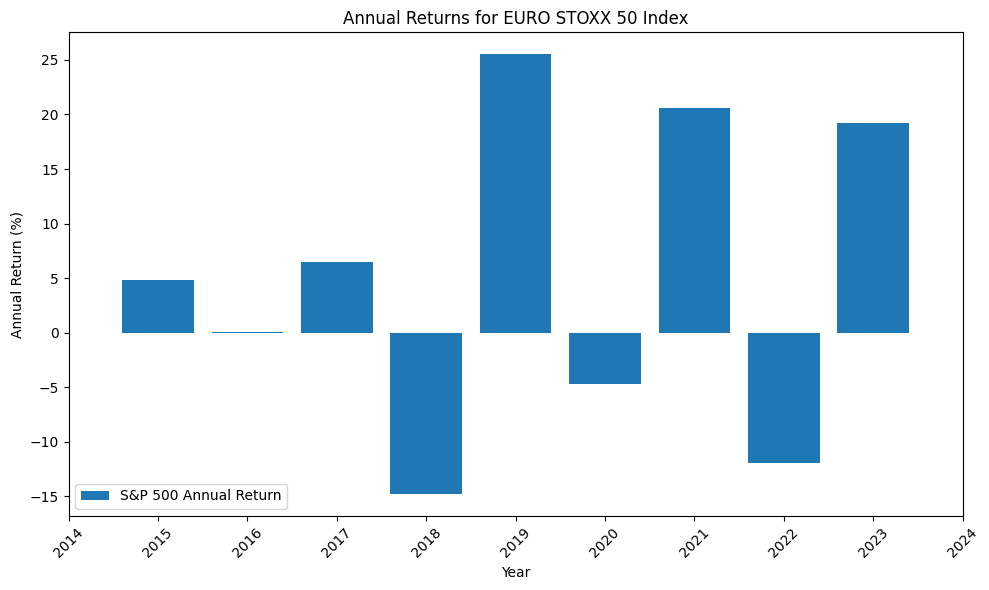

In [384]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(eur50_annual_returns_new['Year'], eur50_annual_returns_new['Annual_Return_new'], label='S&P 500 Annual Return')

ax.set_xticks(eur50_annual_returns_new['Year'])
ax.set_xticklabels(eur50_annual_returns_new['Year'], rotation=45)

plt.xlabel('Year')
plt.ylabel('Annual Return (%)')
plt.title('Annual Returns for EURO STOXX 50 Index')
plt.legend()
plt.tight_layout()
plt.show()

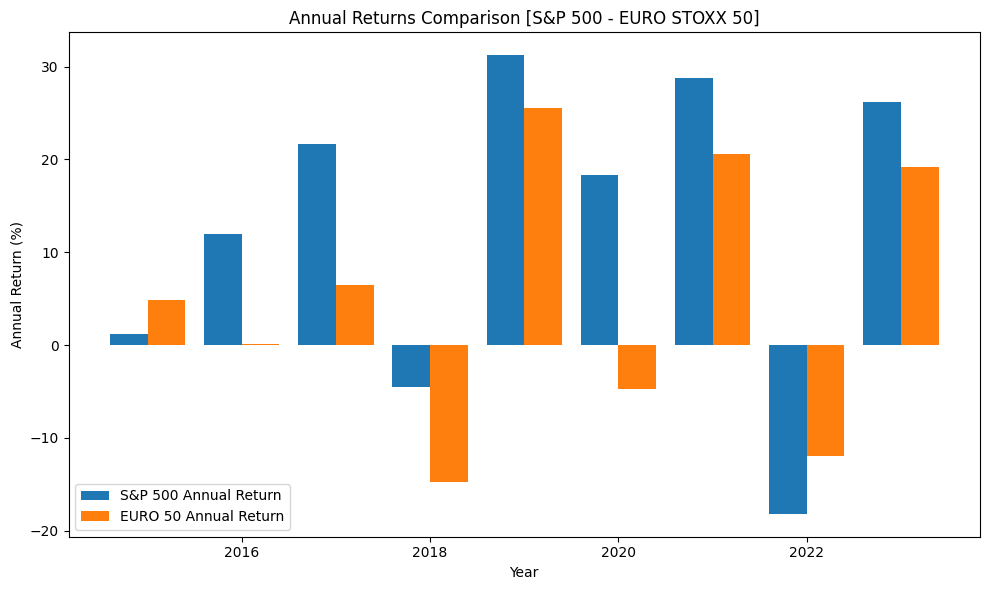

In [385]:
annual_returns_combined = pd.merge(
    sp500_annual_returns_new, eur50_annual_returns_new,
    on='Year',
    how='outer',
    suffixes=('_SP500','_EURO50')
  ).sort_values('Year')

plt.figure(figsize=(10, 6))
plt.bar(annual_returns_combined['Year'] - 0.2, annual_returns_combined['Annual_Return_new_SP500'], width=0.4, label='S&P 500 Annual Return')
plt.bar(annual_returns_combined['Year'] + 0.2, annual_returns_combined['Annual_Return_new_EURO50'], width=0.4, label='EURO 50 Annual Return')

plt.xlabel('Year')
plt.ylabel('Annual Return (%)')
plt.title('Annual Returns Comparison [S&P 500 - EURO STOXX 50]')
plt.legend()
plt.tight_layout()
plt.show()

###Average daily return trend for the S&P 500 and EURO STOXX 50 indices

Below are the average daily returns of the two indices: S&P 500 and EURO STOXX 50.

In [386]:
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
sp500_mean_daily_returns['Day_of_Week'] = pd.Categorical(sp500_mean_daily_returns['Day_of_Week'], categories=days_order, ordered=True)
eur50_mean_daily_returns['Day_of_Week'] = pd.Categorical(eur50_mean_daily_returns['Day_of_Week'], categories=days_order, ordered=True)
sp500_mean_daily_returns = sp500_mean_daily_returns.sort_values('Day_of_Week')
eur50_mean_daily_returns = eur50_mean_daily_returns.sort_values('Day_of_Week')

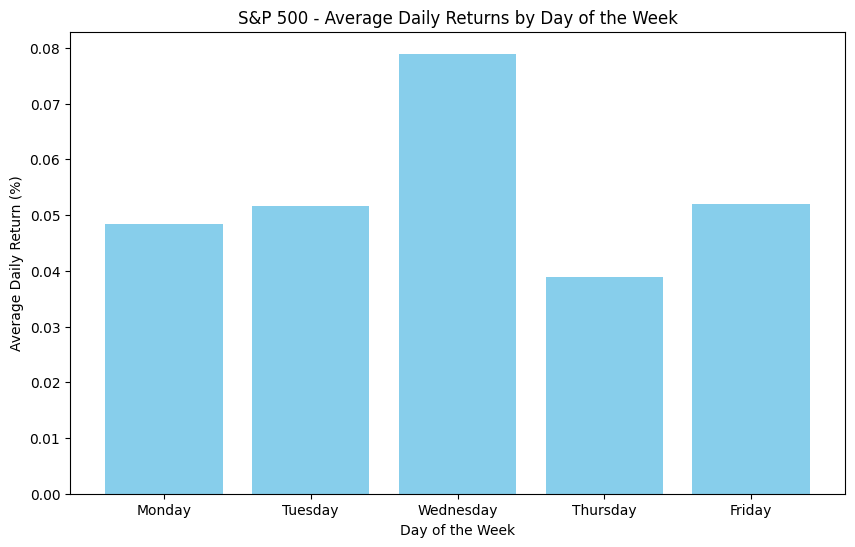

In [387]:
plt.figure(figsize=(10, 6))
plt.bar(sp500_mean_daily_returns['Day_of_Week'], sp500_mean_daily_returns['Daily_Return'], color='skyblue')
plt.xlabel('Day of the Week')
plt.ylabel('Average Daily Return (%)')
plt.title('S&P 500 - Average Daily Returns by Day of the Week')
plt.show()

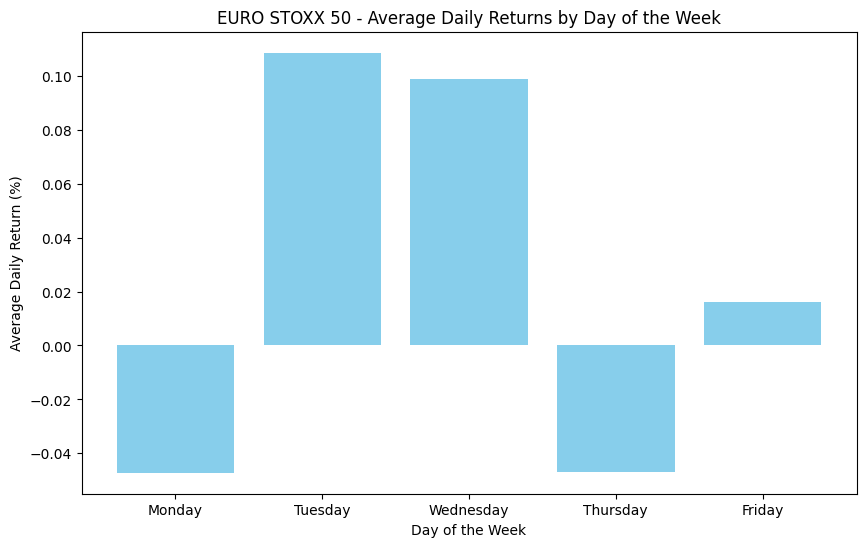

In [388]:
plt.figure(figsize=(10, 6))
plt.bar(eur50_mean_daily_returns['Day_of_Week'], eur50_mean_daily_returns['Daily_Return'], color='skyblue')
plt.xlabel('Day of the Week')
plt.ylabel('Average Daily Return (%)')
plt.title('EURO STOXX 50 - Average Daily Returns by Day of the Week')
plt.show()

###Comparison of the average daily performance of the two indices S&P 500 and EURO STOXX 50

Below is a bar chart showing a comparison between the average daily returns of the S&P 500 index and the EURO STOXX 50 index.

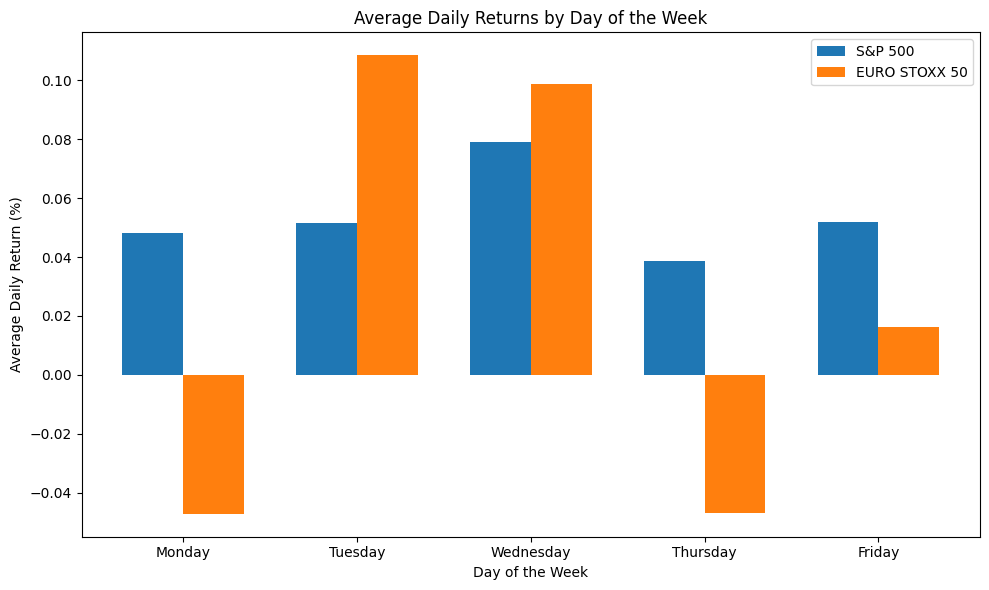

In [389]:
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35
index = np.arange(len(days_order))

ax.bar(index, sp500_mean_daily_returns['Daily_Return'], bar_width, label='S&P 500')
ax.bar(index + bar_width, eur50_mean_daily_returns['Daily_Return'], bar_width, label='EURO STOXX 50')

ax.set_xlabel('Day of the Week')
ax.set_ylabel('Average Daily Return (%)')
ax.set_title('Average Daily Returns by Day of the Week')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(days_order)
ax.legend()

plt.tight_layout()
plt.show()

###Summary presentation of daily returns

Below is a summary representation (via box plot) of the daily returns for the two indices, with the minimum, maximum and average value also highlighted for each.

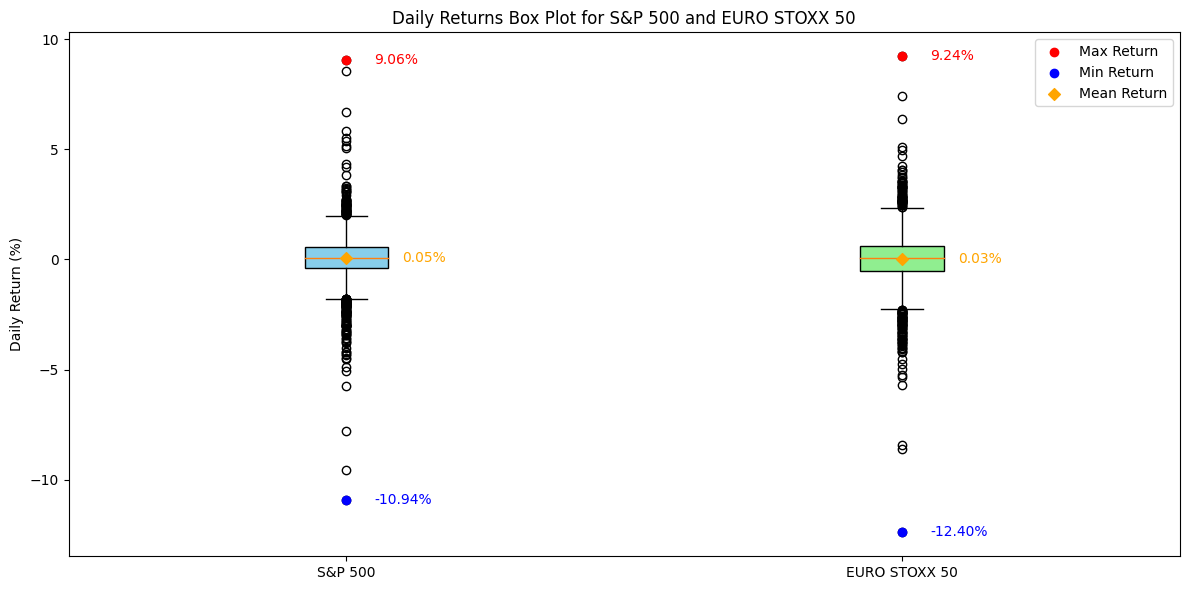

In [390]:
sp500_daily_returns = df['Daily_Return'].dropna().tolist()
eur50_daily_returns = df1['Daily_Return'].dropna().tolist()

max_return_sp500 = max(sp500_daily_returns)
min_return_sp500 = min(sp500_daily_returns)
max_return_eur50 = max(eur50_daily_returns)
min_return_eur50 = min(eur50_daily_returns)

mean_return_sp500 = np.mean(sp500_daily_returns)
mean_return_eur50 = np.mean(eur50_daily_returns)

fig, ax = plt.subplots(figsize=(12, 6))

box = ax.boxplot([sp500_daily_returns, eur50_daily_returns], patch_artist=True, labels=['S&P 500', 'EURO STOXX 50'])

colors = ['skyblue', 'lightgreen']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

ax.scatter([1, 2], [max_return_sp500, max_return_eur50], color='red', label='Max Return', zorder=3)
ax.scatter([1, 2], [min_return_sp500, min_return_eur50], color='blue', label='Min Return', zorder=3)

ax.scatter([1], [mean_return_sp500], color='orange', label='Mean Return', zorder=3, marker='D')
ax.scatter([2], [mean_return_eur50], color='orange', zorder=3, marker='D')

ax.text(1.05, max_return_sp500, f'{max_return_sp500:.2f}%', color='red', verticalalignment='center')
ax.text(2.05, max_return_eur50, f'{max_return_eur50:.2f}%', color='red', verticalalignment='center')
ax.text(1.05, min_return_sp500, f'{min_return_sp500:.2f}%', color='blue', verticalalignment='center')
ax.text(2.05, min_return_eur50, f'{min_return_eur50:.2f}%', color='blue', verticalalignment='center')

ax.text(1.1, mean_return_sp500, f'{mean_return_sp500:.2f}%', color='orange', verticalalignment='center')
ax.text(2.1, mean_return_eur50, f'{mean_return_eur50:.2f}%', color='orange', verticalalignment='center')

ax.set_title('Daily Returns Box Plot for S&P 500 and EURO STOXX 50')
ax.set_ylabel('Daily Return (%)')
ax.legend()

plt.tight_layout()
plt.show()

###Summary of daily volumes

Below is a summary representation (via box plot) of the daily volumes for the two indices, with the minimum, maximum and average value also highlighted for each.

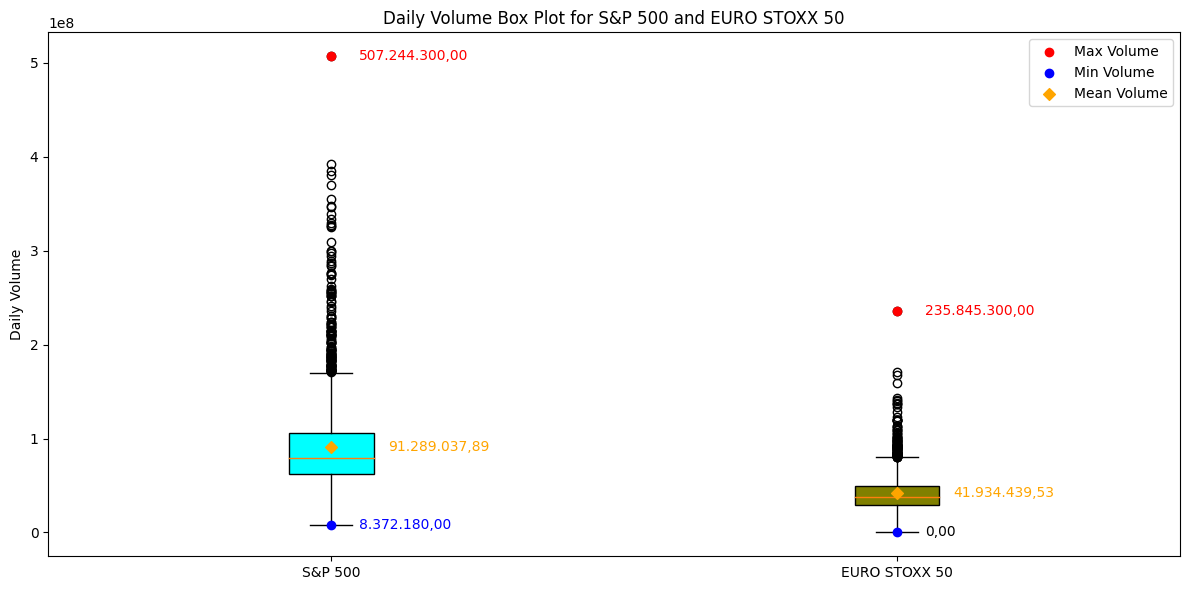

In [391]:
sp500_daily_volume = df['Volume'].dropna().tolist()
eur50_daily_volume = df1['Volume'].dropna().tolist()

max_volume_sp500 = max(sp500_daily_volume)
min_volume_sp500 = min(sp500_daily_volume)
max_volume_eur50 = max(eur50_daily_volume)
min_volume_eur50 = min(eur50_daily_volume)

mean_volume_sp500 = np.mean(sp500_daily_volume)
mean_volume_eur50 = np.mean(eur50_daily_volume)

def format_with_separator(value):
    return '{:,.2f}'.format(value).replace(',', 'X').replace('.', ',').replace('X', '.')

fig, ax = plt.subplots(figsize=(12, 6))

box = ax.boxplot([sp500_daily_volume, eur50_daily_volume], patch_artist=True, labels=['S&P 500', 'EURO STOXX 50'])

colors = ['cyan', 'olive']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

ax.scatter([1, 2], [max_volume_sp500, max_volume_eur50], color='red', label='Max Volume', zorder=3)
ax.scatter([1, 2], [min_volume_sp500, min_volume_eur50], color='blue', label='Min Volume', zorder=3)

ax.scatter([1], [mean_volume_sp500], color='orange', label='Mean Volume', zorder=3, marker='D')
ax.scatter([2], [mean_volume_eur50], color='orange', zorder=3, marker='D')

ax.text(1.05, max_volume_sp500, format_with_separator(max_volume_sp500), color='red', verticalalignment='center')
ax.text(2.05, max_volume_eur50, format_with_separator(max_volume_eur50), color='red', verticalalignment='center')
ax.text(1.05, min_volume_sp500, format_with_separator(min_volume_sp500), color='blue', verticalalignment='center')
ax.text(2.05, min_volume_eur50, format_with_separator(min_volume_eur50), verticalalignment='center')

ax.text(1.1, mean_volume_sp500, format_with_separator(mean_volume_sp500), color='orange', verticalalignment='center')
ax.text(2.1, mean_volume_eur50, format_with_separator(mean_volume_eur50), color='orange', verticalalignment='center')

ax.set_title('Daily Volume Box Plot for S&P 500 and EURO STOXX 50')
ax.set_ylabel('Daily Volume')
ax.legend()

plt.tight_layout()
plt.show()